Import libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config

from warnings import simplefilter

# Reload the packages at each run
%load_ext autoreload
%autoreload 2

# Suppress the specific RuntimeWarning from statsforecast to keep the output clean
simplefilter(action="ignore", category=RuntimeWarning)
simplefilter(action="ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 1. Initial Exploration

<h3> Analyze original dataset </h3>

In [3]:
from utils.preprocess_dataset import load_data
df = load_data()

2025-12-01 12:44:18,375 - utils.preprocess_dataset - INFO - --- Found existing dataset at /home/voron/master_thesis/data/raw/online_retail_II.csv. Loading from file. ---
2025-12-01 12:44:19,526 - utils.preprocess_dataset - INFO - --- DataFrame loaded successfully. ---


In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [6]:
print(f"Dataset contains {df.StockCode.nunique()} unique time series (products)")

Dataset contains 5305 unique time series (products)


<p> We can already see some inconsistencies, that we would want to address during cleaning: data types, column names, and missing values </p>

In [7]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Quantity,Price,Customer ID
count,1.06737e+06,1.06737e+06,824364
mean,9.9389,4.64939,15324.6
std,172.706,123.553,1697.46
min,-80995,-53594.4,12346
25%,1,1.25,13975
50%,3,2.1,15255
75%,10,4.15,16797
max,80995,38970,18287


<h3> Analyze Cleaned Dataset </h3>

In [8]:
from utils.preprocess_dataset import clean_data
df_clean = clean_data(df)

2025-12-01 12:44:44,282 - utils.preprocess_dataset - INFO - --- Found existing cleaned dataset. Loading from /home/voron/master_thesis/data/processed/cleaned_dataset.parquet ---


In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003737 entries, 0 to 1003736
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1003737 non-null  string        
 1   StockCode    1003737 non-null  string        
 2   Quantity     1003737 non-null  int64         
 3   InvoiceDate  1003737 non-null  datetime64[ns]
 4   Price        1003737 non-null  float64       
 5   CustomerID   1003737 non-null  string        
 6   Country      1003737 non-null  string        
dtypes: datetime64[ns](1), float64(1), int64(1), string(4)
memory usage: 53.6 MB


In [10]:
print(f"Cleaned dataset contains {df_clean.StockCode.nunique()} unique time series (products)")

Cleaned dataset contains 4909 unique time series (products)


In [11]:
df_clean.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Quantity,InvoiceDate,Price
count,1.00374e+06,1.00374e+06,1.00374e+06
mean,11.1465,g,3.37455
min,1,g,0.03
25%,1,g,1.25
50%,4,g,2.1
75%,12,g,4.13
max,80995,g,11062.1
std,128.713,nan,13.1164


# 2. Asessing the Coverage

<h2>2.1 Number of unique dates of sale for each product</h2>

<p> Here we want to understand how many unique dates are present for each product as a proxy for longetivity of its sales </p>

In [13]:
save_dir = config.RESULTS_DIR / "reports"
save_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
df1 = df_clean.loc[:, ['StockCode', 'InvoiceDate']]
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate']).dt.date
# Sort by unique days sold (High -> Low)
df_group = df1.groupby('StockCode').nunique().sort_values(by='InvoiceDate', ascending=False)

2025-12-01 13:11:22,491 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-01 13:11:22,497 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


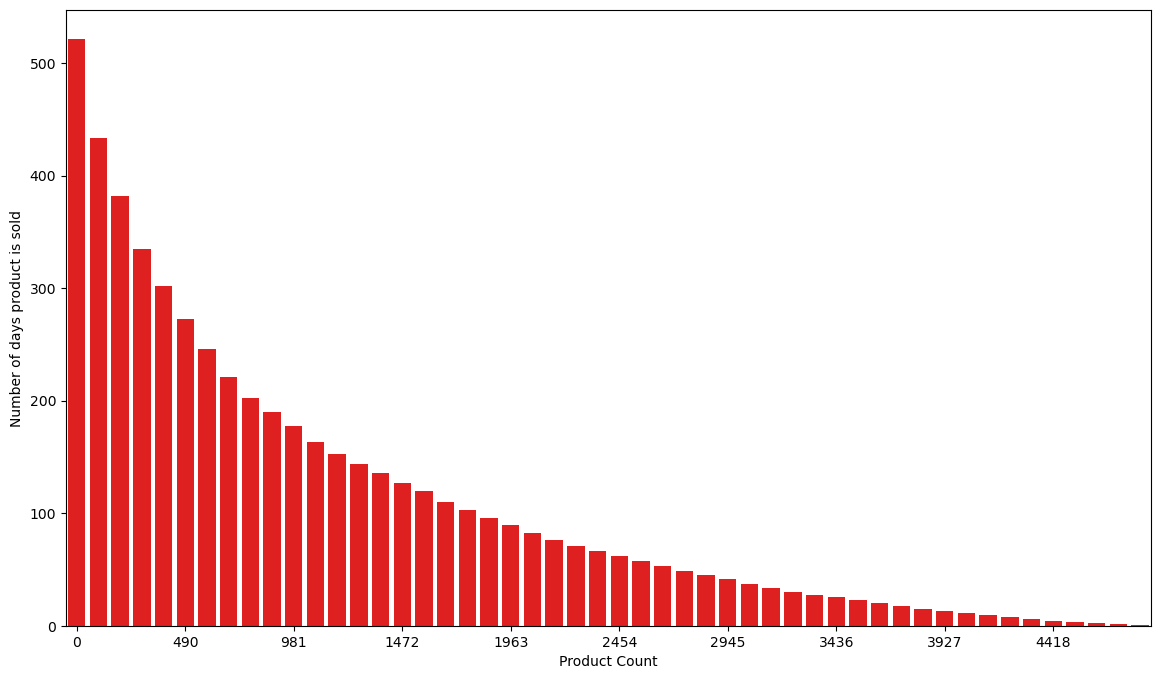

In [26]:
df1=df_clean.loc[:,['StockCode', 'InvoiceDate']]
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate']).dt.date
df_group = df1.groupby('StockCode').nunique().sort_values(by='InvoiceDate', ascending=False)
TOTAL_BINS = 50
products_per_bin = len(df_group) / TOTAL_BINS
df_binned = df_group.reset_index(drop=True)
df_binned['bin_id'] = pd.cut(df_binned.index, bins=TOTAL_BINS, labels=False)
df_plot = df_binned.groupby('bin_id')['InvoiceDate'].mean()
plt.figure(figsize=(14,8))
sns.barplot(x=df_plot.index, y=df_plot.values, color='red')
plt.xlabel('Product Count')
plt.ylabel('Number of days product is sold')
locs = np.arange(0, TOTAL_BINS, 5)
labels = [int(loc * products_per_bin) for loc in locs]
plt.xticks(locs, labels)
plt.savefig(save_dir / f"vol_coverage.png", dpi=300)

<h2> 2.2 Range of dates product type is sold </h2>

<p> As the previous analysis counted each specific order as a separate purchase event, here we assess how long was each product selling by finding delta between the first order date and the last </p>

2025-12-01 13:11:34,554 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-01 13:11:34,560 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


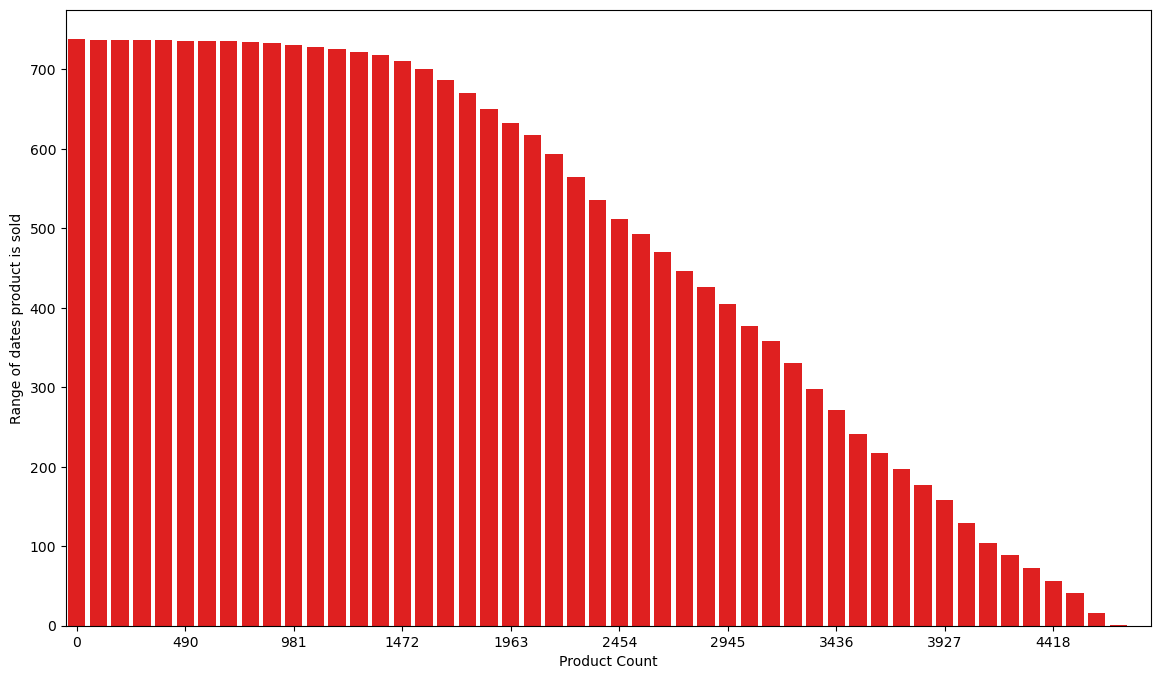

In [27]:
df2=df_clean.loc[:,['StockCode', 'InvoiceDate']]
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])
df_group = df2.groupby('StockCode')['InvoiceDate'].agg(lambda x: (x.max() - x.min()).days)
df_group = df_group.sort_values(ascending=False).reset_index(name='date_diff')
TOTAL_BINS = 50
products_per_bin = len(df_group) / TOTAL_BINS
df_group['bin_id'] = pd.cut(df_group.index, bins=TOTAL_BINS, labels=False)
df_plot = df_group.groupby('bin_id')['date_diff'].mean()
plt.figure(figsize=(14,8))
sns.barplot(x=df_plot.index, y=df_plot.values, color='red')
plt.xlabel('Product Count')
plt.ylabel('Range of dates product is sold')
locs = np.arange(0, TOTAL_BINS, 5)
labels = [int(loc * products_per_bin) for loc in locs]
plt.xticks(locs, labels)
plt.savefig(save_dir / f"vol_range.png", dpi=300)

<p> This gives us an insight that we could encounter some problems after splitting the data in the defined sets, as some of the test sets could potentially contain products that were not seen during training. While it is not a problem for standalone models, it is a problem for baselines </p>

2025-12-01 13:18:36,780 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-01 13:18:36,785 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-01 13:18:36,887 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-01 13:18:36,891 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


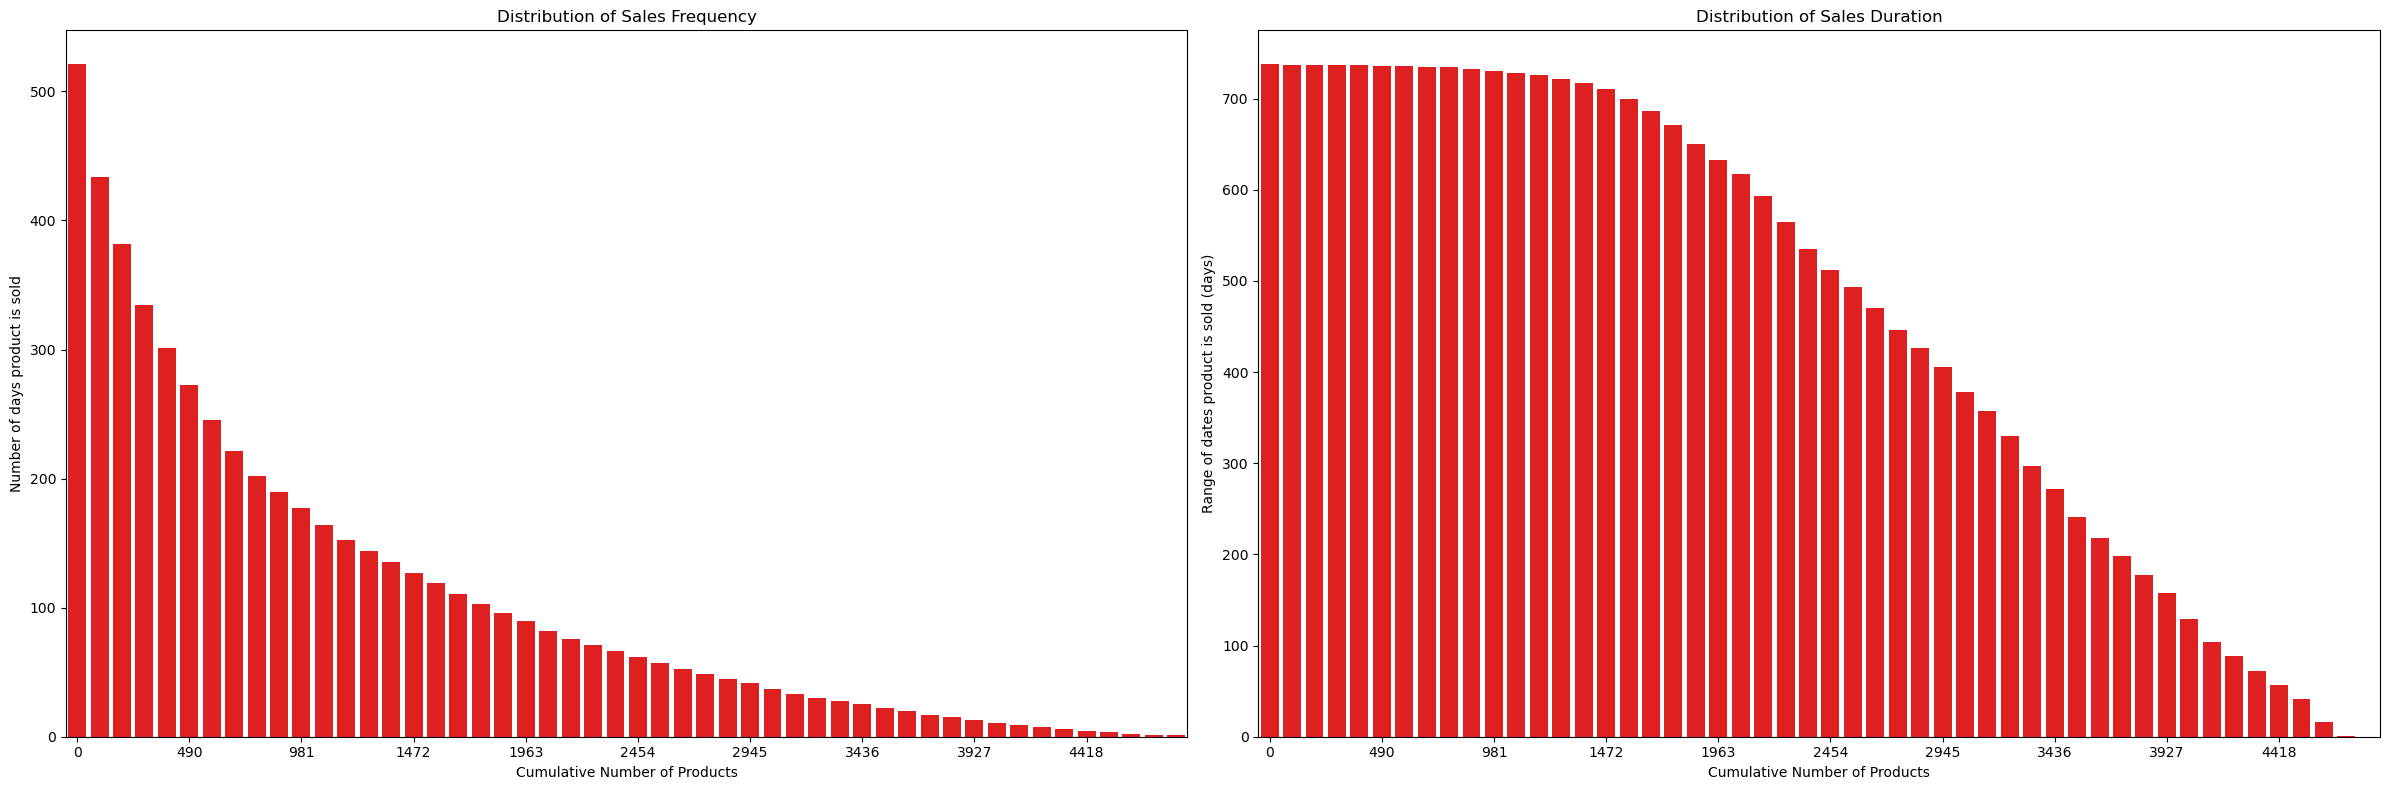

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
df1 = df_clean.loc[:,['StockCode', 'InvoiceDate']]
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate']).dt.date
df2 = df_clean.loc[:,['StockCode', 'InvoiceDate']]
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])
# Group and Sort
df_group1 = df1.groupby('StockCode')['InvoiceDate'].nunique().sort_values(ascending=False).reset_index(name='unique_days')
df_group2 = df2.groupby('StockCode')['InvoiceDate'].agg(lambda x: (x.max() - x.min()).days)
df_group2 = df_group2.sort_values(ascending=False).reset_index(name='date_diff')
# Binning logic
TOTAL_BINS = 50
products_per_bin = len(df_group1) / TOTAL_BINS
df_group1['bin_id'] = pd.cut(df_group1.index, bins=TOTAL_BINS, labels=False)
products_per_bin2 = len(df_group2) / TOTAL_BINS
df_group2['bin_id'] = pd.cut(df_group2.index, bins=TOTAL_BINS, labels=False)
# Aggregate
df_plot1 = df_group1.groupby('bin_id')['unique_days'].mean()
df_plot2 = df_group2.groupby('bin_id')['date_diff'].mean()
# Plot
sns.barplot(x=df_plot1.index, y=df_plot1.values, color='red', ax=axes[0])
sns.barplot(x=df_plot2.index, y=df_plot2.values, color='red', ax=axes[1])
axes[0].set_xlabel('Cumulative Number of Products')
axes[0].set_ylabel('Number of days product is sold')
axes[0].set_title('Distribution of Sales Frequency')
axes[1].set_xlabel('Cumulative Number of Products')
axes[1].set_ylabel('Range of dates product is sold (days)')
axes[1].set_title('Distribution of Sales Duration')
locs = np.arange(0, TOTAL_BINS, 5)
labels = [int(loc * products_per_bin) for loc in locs]
axes[0].set_xticks(locs)
axes[0].set_xticklabels(labels)
locs = np.arange(0, TOTAL_BINS, 5)
labels = [int(loc * products_per_bin2) for loc in locs]
axes[1].set_xticks(locs)
axes[1].set_xticklabels(labels)
plt.tight_layout()
plt.savefig(save_dir / "date_coverage.png", dpi=300)


# 3. Asessing Variability Distribution

<h2> 3.1 Assessing CoV for Days </h2>

<p> Here, we are looking at the distribution of CoV, as to have a preliminary understanding of the kind products in the dataset and understand if the proposed segmentation intervals are correct </p>

In [30]:
df3 = df_clean.loc[:, ['StockCode','InvoiceDate','Quantity']]
df3['InvoiceDate'] = pd.to_datetime(df3['InvoiceDate'])
df3['InvoiceDate'] = df3['InvoiceDate'].dt.date
df3 = df3.groupby(['StockCode', 'InvoiceDate']).sum().reset_index()
df3 = df3.loc[:, ['StockCode', 'Quantity']]
df3 = df3.groupby('StockCode').agg(['mean', 'std'])['Quantity'].reset_index()
df3['CoV'] = df3['std'] / df3['mean']
df3['CoV'] = df3['CoV'].fillna(0)
df3 = df3.sort_values(by='CoV', ascending=False)
df3=df3[df3['mean']>0]
df3.CoV.describe()


count    4909.000000
mean        1.528997
std         1.078176
min         0.000000
25%         0.912871
50%         1.314886
75%         1.889538
max        10.629166
Name: CoV, dtype: float64

In [33]:
print(df3[df3['CoV']<0.5].count())
print(df3[(df3['CoV']>=0.5) & (df3['CoV']<1)].count())
print(df3[df3['CoV']>=1].count())

StockCode    486
mean         486
std          309
CoV          486
dtype: int64
StockCode    1001
mean         1001
std          1001
CoV          1001
dtype: int64
StockCode    3422
mean         3422
std          3422
CoV          3422
dtype: int64


<p> It is evident that when looking at daily variations, the variability is too high due to the B2B nature of product. During some days we could see one large order, while during several others only smaller ones.

<h2> 3.2 Assessing CoV for Weeks </h2>

Therefore, we are moving to the weekly frame, meaning that not only the CoV will be based on the weekly demand, but we will be making our predictions on the weekly basis too.

In [32]:
df4 = df_clean.loc[:, ['StockCode','InvoiceDate','Quantity']]
df4['InvoiceDate'] = pd.to_datetime(df4['InvoiceDate'])
df4['Week'] = df4['InvoiceDate'].dt.isocalendar().week  # Extract week number
df4['InvoiceDate'] = df4['InvoiceDate'].dt.year  # Extract year
df4 = df4.groupby(['StockCode', 'InvoiceDate', 'Week'])['Quantity'].sum().reset_index() #Aggregate by StockCode, Year and Week
df4 = df4.loc[:, ['StockCode', 'Quantity']]
df4 = df4.groupby('StockCode').agg(['mean', 'std'])['Quantity'].reset_index()
df4['CoV'] = df4['std'] / df4['mean']
df4['CoV'] = df4['CoV'].fillna(0)
df4 = df4.sort_values(by='CoV', ascending=False)
df4=df4[df4['mean']>0]
df4.CoV.describe()

count    4909.000000
mean        1.216543
std         0.795069
min         0.000000
25%         0.773452
50%         1.068077
75%         1.504623
max         7.197141
Name: CoV, dtype: float64

In [34]:
print(df4[df4['CoV']<0.5].count())
print(df4[(df4['CoV']>=0.5) & (df4['CoV']<1)].count())
print(df4[df4['CoV']>=1].count())


StockCode    514
mean         514
std          321
CoV          514
dtype: int64
StockCode    1689
mean         1689
std          1689
CoV          1689
dtype: int64
StockCode    2706
mean         2706
std          2706
CoV          2706
dtype: int64


<p> Although the distribution is cleaner now across segments, we can clearly see that we are dealing with the products with relatively high variability in demand </p>

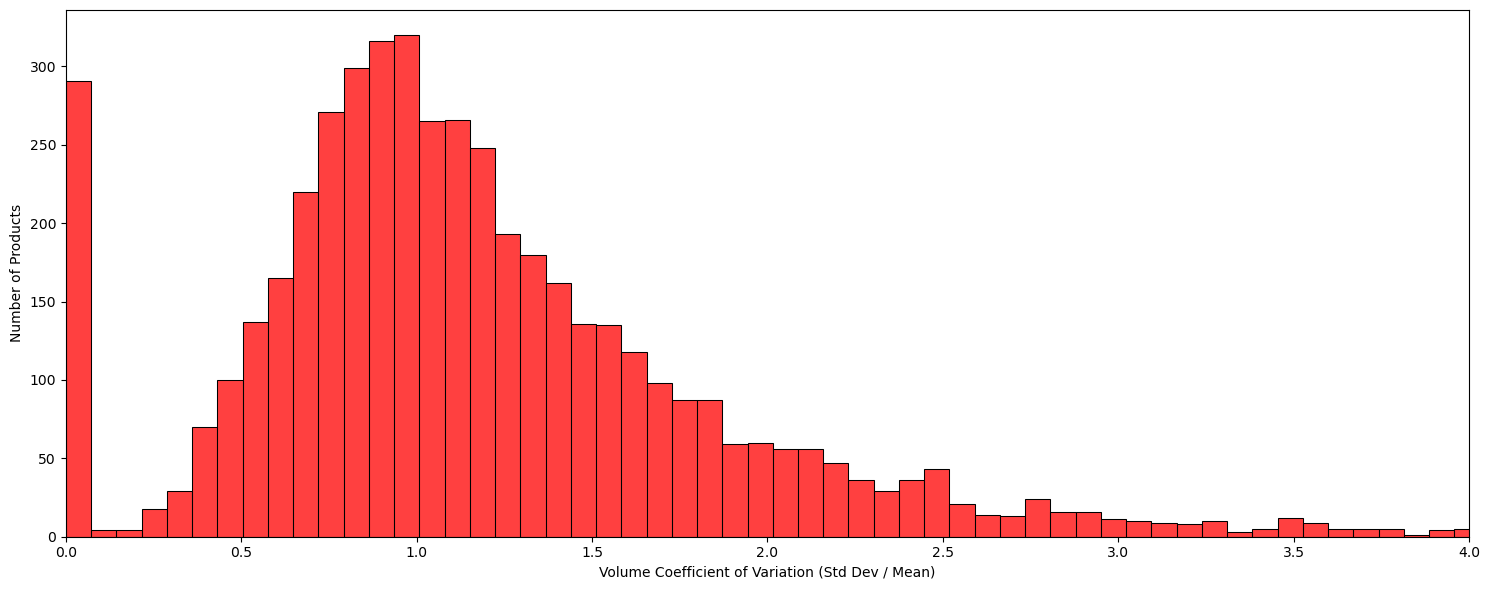

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=[15, 6])
sns.histplot(data=df4, x='CoV', bins=100, kde=False, color='red')
plt.xlabel('Volume Coefficient of Variation (Std Dev / Mean)')
plt.ylabel('Number of Products')
plt.xlim(0, 4)

plt.tight_layout()

plt.show()
plt.savefig(save_dir / f"vol_volat.png", dpi=300)

# 4. Asessing Price Variability

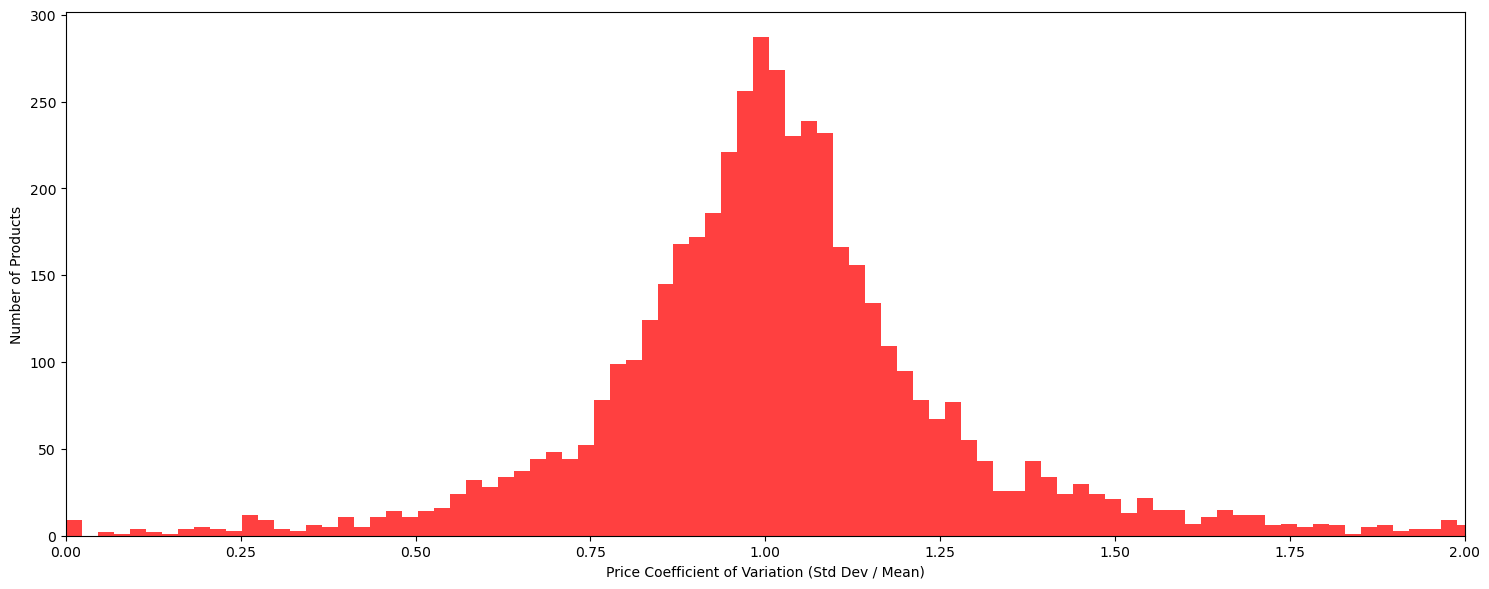

<Figure size 640x480 with 0 Axes>

In [45]:
# Ensure Price is numeric
df['Price'] = pd.to_numeric(df_clean['Price'], errors='coerce')
df = df.dropna(subset=['Price'])
df_positive_price = df[df['Price'] > 0]

# --- 1. Calculate Price CoV per product ---
price_stats = df_positive_price.groupby('StockCode')['Price'].agg(['mean', 'std', 'count']).reset_index()
price_stats = price_stats[price_stats['count'] > 1] 
price_stats['std'] = price_stats['std'].fillna(0) 
price_stats['PriceCoV'] = price_stats['std'] / (price_stats['mean'] + 1e-6)

# --- 2. Create Plots ---
plt.figure(figsize=[15, 6])
sns.histplot(data=price_stats, x='PriceCoV', bins=1000, kde=False, color='red', linewidth=0)
plt.xlabel('Price Coefficient of Variation (Std Dev / Mean)')
plt.ylabel('Number of Products')
plt.xlim(0, 2)

# --- 3. Display ---
plt.tight_layout()

plt.show()
plt.savefig(save_dir / f"price_volat.png", dpi=300)


# 5. Check the parameters to determine BMA weights

In [5]:
import config
import numpy as np
import torch
import torch.nn.functional as F

# --- 1. Load your actual data (Replace paths if needed) ---

def inspect_params(model_name, params_array):
    """
    params_array: Shape (N, Horizon, Seeds, 3) or (N, Horizon, 3)
    """
    print(f"\n--- Diagnosing {model_name} ---")
    
    # Handle seeds dimension if present
    if params_array.ndim == 4:
        params_array = params_array.mean(axis=2) # Average over seeds for inspection
        
    mu = params_array[..., 0]
    alpha = params_array[..., 1]
    gate = params_array[..., 2]
    
    print(f"Mean(Mu):   {np.mean(mu):.4f}  [Expected ~20.0?]")
    print(f"Max(Mu):    {np.max(mu):.4f}")
    print(f"Min(Mu):    {np.min(mu):.4f}")
    
    print(f"Mean(Alpha): {np.mean(alpha):.4f}")
    print(f"Mean(Gate):  {np.mean(gate):.4f}")
    
    # Check for "Double Activation" or "Missing Activation"
    # If Mean(Mu) is ~3.0, it's likely raw logits (Log-Space).
    # If Mean(Mu) is ~20.0, it's likely linear space (Correct).
    # If Mean(Mu) is HUGE (e.g. e^20), it's double activated.
    
    if np.mean(mu) < 5.0:
        print(">> WARNING: Mu seems very small. Is it in Log Space (Logits)?")
        print(f"   If so, Expected Mu = exp({np.mean(mu):.2f}) = {np.exp(np.mean(mu)):.2f}")
    elif np.mean(mu) > 1000.0:
        print(">> WARNING: Mu seems HUGE. Was it activated twice?")

    # --- Manual Log Likelihood Check (Simplified NB) ---
    target = 20.0 
    
    # Let's calculate LL for a single average point
    avg_mu = np.mean(mu)
    avg_alpha = np.mean(alpha)
    
    # PyTorch check
    t_mu = torch.tensor([avg_mu])
    t_alpha = torch.tensor([avg_alpha])
    
    total_count = 1.0 / t_alpha
    p = 1.0 / (1.0 + t_alpha * t_mu)
    
    # Instantiate NB
    try:
        nb = torch.distributions.NegativeBinomial(total_count=total_count, probs=p)
        ll = nb.log_prob(torch.tensor([target]))
        print(f"LogLikelihood for Target={target} given Mean={avg_mu:.2f}: {ll.item():.4f}")
    except Exception as e:
        print(f"LL Calc Failed: {e}")

# --- MOCK USE CASE ---
# Load your actual .npz or .pkl files here
deepar_params = np.load(config.FORECASTS_DIR / "DeepAR" / "test_predictions_deepar_fold1.npz")
tft_params = np.load(config.FORECASTS_DIR / "TFT" / 'test_predictions_tft_fold1.npz')
deeptcn_params = np.load(config.FORECASTS_DIR / "DeepTCN" / 'test_predictions_deeptcn_fold1.npz')
inspect_params("DeepAR", deepar_params['val_params'])
inspect_params("TFT", tft_params['val_params'])
inspect_params("DeepTCN", deeptcn_params['val_params'])



--- Diagnosing DeepAR ---
Mean(Mu):   53.8703  [Expected ~20.0?]
Max(Mu):    2280.2000
Min(Mu):    0.0001
Mean(Alpha): 14.4705
Mean(Gate):  0.7683
LogLikelihood for Target=20.0 given Mean=53.87: -138.6259

--- Diagnosing TFT ---
Mean(Mu):   45.4680  [Expected ~20.0?]
Max(Mu):    670.5385
Min(Mu):    0.2454
Mean(Alpha): 2.7930
Mean(Gate):  0.2840
LogLikelihood for Target=20.0 given Mean=45.47: -99.8821

--- Diagnosing DeepTCN ---
Mean(Mu):   22.5303  [Expected ~20.0?]
Max(Mu):    239.5285
Min(Mu):    0.0019
Mean(Alpha): 2.6169
Mean(Gate):  0.3205
LogLikelihood for Target=20.0 given Mean=22.53: -84.5806
